# 5 - Telco Customer Churn: Revisiting Predictive Modeling
## Predictive Models
### Alden Chico

---

## Premise

In the last step of the project, we reexamined the Telco telecommunication service's data to determine if there were more intelligent ways to filter data before running it through predictive modeling. We found that users were around 8% more likely to churn if they paid $75 per month for Telco's services. Since we know that users were more likely to churn if they were paying this amount, we filtered out users that were paying less than $75 per month to improve our predictive models' performance.

Beyond that, we also explored feature selection using Chi-Squared testing. We discussed the significance of Chi-Squared testing when it came to feature dependence and selected 10 new features to model on using the highest valued chi-squared statistics.

With a set of ten new features along with filtering for users that are paying $75 per month or more, we are now prepared to model our data with this new information. We will go through the same data modeling steps as we did last time, escalating the complexity of our data models from logistic regression, decision tree classification, and random forest classification. After fitting our data to these models, we will predict on a holdout set for evaluation for each dataset and compare F1 and accuracy between the different models. In the end, we will make empirical conclusions based on our model's performance and future suggestions for Telco to improve their customer retention.

---

## Importing Telco Churn Datasets

Before we can begin modeling our data, let's start by importing the old and revised selected feature datasets using Pandas.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Import the Telco churn dataset with selected OHE features from CSV file
data_clean = pd.read_csv('output/2-EDA/clean_telco.csv', index_col='customerID')
data_clean = data_clean.drop('Unnamed: 0', axis=1)
data_clean.head()

,gender_Female,gender_Male,OnlineSecurity_No,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,TechSupport_No,StreamingMovies_No,Contract_Month-to-month,PaymentMethod_Electronic check,tenure,MonthlyCharges,TotalCharges,churn
customerID,,,,,,,,,,,,,,
7590-VHVEG,1,0,1,0,1,1,1,1,1,1,1,29.85,29.85,0
5575-GNVDE,0,1,0,1,0,0,1,1,0,0,34,56.95,1889.50,0
3668-QPYBK,0,1,0,0,1,1,1,1,1,0,2,53.85,108.15,1
7795-CFOCW,0,1,0,1,0,0,0,1,0,0,45,42.30,1840.75,0
9237-HQITU,1,0,1,1,0,1,1,1,1,1,2,70.70,151.65,1


In [3]:
# Import the Telco churn dataset with selected OHE features from CSV file
data_new = pd.read_csv('output/5-EDA_Revisited/new_selected_features.csv', index_col='customerID')
data_new.head()

,DeviceProtection_No internet service,OnlineBackup_No internet service,OnlineSecurity_No internet service,InternetService_No,InternetService_Fiber optic,TechSupport_No,OnlineSecurity_No,PaymentMethod_Electronic check,Contract_Two year,Contract_Month-to-month,churn,MonthlyCharges,tenure
customerID,,,,,,,,,,,,,
9305-CDSKC,0,0,0,0,1,1,1,1,0,1,1,99.65,8
1452-KIOVK,0,0,0,0,1,1,1,0,0,1,0,89.10,22
7892-POOKP,0,0,0,0,1,0,1,1,0,1,1,104.80,28
8091-TTVAX,0,0,0,0,1,1,1,0,0,0,0,100.35,58
0280-XJGEX,0,0,0,0,1,1,1,0,0,1,1,103.70,49


---

## Preparing the Results Function

We will be using the ```plot_results``` function that we've been using to evaluate predictive models for this section of our project as well. The ```plot_results``` function prints the classification report and confusion matrix between churn predictions and their actual labels. If output_dict is True, then the function only returns the values from the classification report in the format of a dictionary.

In [4]:
# Function that plots confusion matrix / classification report after making predictions
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def plot_results(y_test, y_pred, output_dict=False):
    cr = classification_report(y_test, y_pred, output_dict=output_dict)
    # Display results if plot_results doesn't want to return classification report
    if output_dict == False:
        conf_mat = confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(conf_mat, index = ['Did Not Churn', 'Churn'],
                          columns = ['Did Not Churn', 'Churn'])
        _ = sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
        _ = plt.title('Churn Confusion Matrix', fontsize=20)
        _ = plt.ylabel('True', fontsize=14)
        _ = plt.xlabel('Predicted', fontsize=14)
        _ = plt.show()
        print(cr)
    # Only return classification report if desire dictionary results
    return cr

---

## Preparing Data for Modelling

The last time we analyzed predictive modeling between all the features from the dataset and the selected features dataset, we performed a simple train-test split between the datasets. We observed later on that the data is imbalanced with 26.5\% of the data for users that churned and the rest for users that didn't churn. When fitting our models to provided training data, we must be cognizant that the distribution of data is similar to the overall population's distribution to provide the best model performance in a real world situation. Because of this data imbalance, it's much better to use a Stratified Shuffle Split that mirrors the distribution for train-test splits between users that churned and didn't churn. We perform a Stratified Shuffle Split in the code snippet below.

In [5]:
# Stratify training and testing data according to distribution of total sample
from sklearn.model_selection import StratifiedShuffleSplit

X_clean = data_clean.drop('churn', axis=1).values
y_clean = data_clean['churn'].values

sss_clean = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss_clean.split(X_clean, y_clean):
    X_train_clean, X_test_clean = np.array(X_clean[train_index]), np.array(X_clean[test_index])
    y_train_clean, y_test_clean = np.array(y_clean[train_index]), np.array(y_clean[test_index])

print(f'Old Selected Feature Dataset Shape\nX_train_clean:{X_train_clean.shape}\nX_test_clean: {X_test_clean.shape}\ny_train_clean: {y_train_clean.shape}\ny_test_clean: {y_test_clean.shape}')

X_new = data_new.drop('churn', axis=1).values
y_new = data_new['churn'].values

sss_new = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss_clean.split(X_new, y_new):
    X_train_new, X_test_new = np.array(X_new[train_index]), np.array(X_new[test_index])
    y_train_new, y_test_new = np.array(y_new[train_index]), np.array(y_new[test_index])

print(f'Revised Selected Feature Dataset Shape\nX_train_new:{X_train_new.shape}\nX_test_new: {X_test_new.shape}\ny_train_new: {y_train_new.shape}\ny_test_new: {y_test_new.shape}')

Old Selected Feature Dataset Shape
X_train_clean:(5634, 13)
X_test_clean: (1409, 13)
y_train_clean: (5634,)
y_test_clean: (1409,)
Revised Selected Feature Dataset Shape
X_train_new:(2502, 12)
X_test_new: (626, 12)
y_train_new: (2502,)
y_test_new: (626,)


---

## Best Classifier Function

The ```best_clf``` function is the same function that we used from the last predictive modeling step. We take advantage of sklearn's powerful ```GridSearchCV``` function that runs k-fold cross-validation across all combinations of provided model parameters to find the best hyperparameters for a given model.

In [6]:
# Function to find best classifier using GridSearchCV
from sklearn.model_selection import GridSearchCV
# Ignore sklearn FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def best_clf(clf, params, X_train, y_train, cv=3):
    best_clf = GridSearchCV(clf, params, cv=cv)
    _ = best_clf.fit(X_train, y_train)
    return best_clf

---

## Create and Plot Accuracy and F1-Scores to Evaluate Model

The following ```plot_f1_acc``` function plots the F1-Score and accuracy for each model separated by the dataset. Since there are two evaluation metrics and two datasets we'll be modeling on, ```plot_f1_acc``` creates four separate plots.

In [7]:
f1_dict_clean = {}
acc_dict_clean = {}

f1_dict_new = {}
acc_dict_new = {}

In [8]:
# Plot the change in F1-scores over the different NN models
def plot_f1_acc(f1_dict, acc_dict, f1_dict_clean, acc_dict_clean):
    
    fig, axs = plt.subplots(2, 2, figsize=(20,10))
    
    # Gather f1_dict values and keys from all dataset
    list_val = list(f1_dict.values())
    list_keys = list(f1_dict.keys())
    avg_f1_score = np.mean(list_val)
    
    # Gather acc_dict values and keys from all dataset
    list_acc = list(acc_dict.values())
    list_acc_keys = list(acc_dict.keys())
    avg_acc_score = np.mean(list_acc)
    
    # Gather f1_dict values and keys from all dataset
    list_val_clean = list(f1_dict_clean.values())
    list_keys_clean = list(f1_dict_clean.keys())
    avg_f1_score_clean = np.mean(list_val_clean)
    
    # Gather acc_dict values and keys from all dataset
    list_acc_clean = list(acc_dict_clean.values())
    list_acc_keys_clean = list(acc_dict_clean.keys())
    avg_acc_score_clean = np.mean(list_acc_clean)
    
    # Plot F1 Scores for All Dataset
    _ = axs[0][0].plot(list_val, marker='o', color='black', linestyle='solid', 
                 linewidth='2', label='Churn Prediction F1-Score')
    _ = axs[0][0].axhline(avg_f1_score, color='red', linestyle='dashed', label=f'Average F1-Score : {avg_f1_score:.2f}')
    _ = axs[0][0].set_title('F1-Score for Models on Old Selected Variable Dataset', fontsize=14, fontweight='bold')
    _ = axs[0][0].set_xticks(range(len(list_val)))
    _ = axs[0][0].set_xticklabels(list_keys, rotation=60)
    _ = axs[0][0].set_xlabel('Model Description')
    _ = axs[0][0].set_ylabel('F1-Score')
    _ = axs[0][0].legend(loc='lower right')
    
    
    # Plot Accuracy Scores for All Dataset
    _ = axs[0][1].plot(list_acc, marker='o', color='black', linestyle='solid', 
                 linewidth='2', label='Accuracy')
    _ = axs[0][1].axhline(avg_acc_score, color='red', linestyle='dashed', label=f'Average Accuracy : {avg_acc_score:.2f}')
    _ = axs[0][1].set_title('Accuracy for Models on Old Selected Variable Dataset', fontsize=14, fontweight='bold')
    _ = axs[0][1].set_xticks(range(len(list_acc)))
    _ = axs[0][1].set_xticklabels(list_acc_keys, rotation=60)
    _ = axs[0][1].set_xlabel('Model Description')
    _ = axs[0][1].set_ylabel('Accuracy')
    _ = axs[0][1].legend(loc='lower right')
    
    # Plot F1 Scores for Clean Dataset
    _ = axs[1][0].plot(list_val_clean, marker='o', color='black', linestyle='solid', 
                 linewidth='2', label='Churn Prediction F1-Score')
    _ = axs[1][0].axhline(avg_f1_score_clean, color='red', linestyle='dashed', 
                          label=f'Average F1-Score : {avg_f1_score_clean:.2f}')
    _ = axs[1][0].set_title('F1-Score for Models on New Selected Variable Dataset', fontsize=14, fontweight='bold')
    _ = axs[1][0].set_xticks(range(len(list_val_clean)))
    _ = axs[1][0].set_xticklabels(list_keys_clean, rotation=60)
    _ = axs[1][0].set_xlabel('Model Description')
    _ = axs[1][0].set_ylabel('F1-Score')
    _ = axs[1][0].legend(loc='lower right')
    
    
    # Plot Accuracy Scores for Clean Dataset
    _ = axs[1][1].plot(list_acc_clean, marker='o', color='black', linestyle='solid', 
                 linewidth='2', label='Accuracy')
    _ = axs[1][1].axhline(avg_acc_score_clean, color='red', linestyle='dashed', 
                          label=f'Average Accuracy : {avg_acc_score_clean:.2f}')
    _ = axs[1][1].set_title('Accuracy for Models on New Selected Variable Dataset', fontsize=14, fontweight='bold')
    _ = axs[1][1].set_xticks(range(len(list_acc_clean)))
    _ = axs[1][1].set_xticklabels(list_acc_keys_clean, rotation=60)
    _ = axs[1][1].set_xlabel('Model Description')
    _ = axs[1][1].set_ylabel('Accuracy')
    _ = axs[1][1].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

## Logistic Regression Classifier

We showed last time that the simplest binary classification model, logistic regression, performed better than all predictive models that we evaluated. Let's see how logistic regression performs given the newly filtered dataset.

In [9]:
# Create best-fit logistic regression model for all OHE feature dataset and selected OHE feature dataset
from sklearn.linear_model import LogisticRegression


# Parameters for GridSearchCV
lr_params = {'penalty' : ['l1', 'l2'],
          'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'random_state' : [42],
          'fit_intercept': [True, False]}
lr = LogisticRegression()

# Find best random tree classifier for old selected feature dataset
best_lr_clean = best_clf(lr, lr_params, X_train_clean, y_train_clean)

# Find best random tree classifier for new selected feature dataset
best_lr_new = best_clf(lr, lr_params, X_train_new, y_train_new)

# Print list of best parameters from GridSearchCV
print(f'Best Parameters for Logistic Regression on Old Selected Features: {best_lr_clean.best_params_}')
print(f'Best Parameters for Logistic Regression on Revised Selected Features: {best_lr_new.best_params_}')


Best Parameters for Logistic Regression on Old Selected Features: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l1', 'random_state': 42}
Best Parameters for Logistic Regression on Revised Selected Features: {'C': 1, 'fit_intercept': True, 'penalty': 'l1', 'random_state': 42}


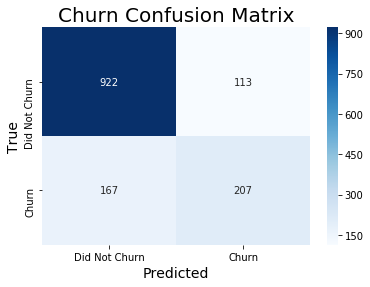

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.55      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



In [10]:
# Generate results from random forest on old selected feature dataset
y_pred_clean_lr = best_lr_clean.predict(X_test_clean)
_ = plot_results(y_test_clean, y_pred_clean_lr)
cr_lr_clean = plot_results(y_test_clean, y_pred_clean_lr, output_dict=True)

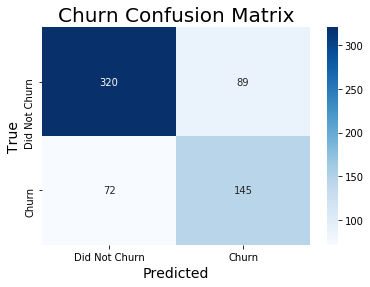

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       409
           1       0.62      0.67      0.64       217

    accuracy                           0.74       626
   macro avg       0.72      0.73      0.72       626
weighted avg       0.75      0.74      0.74       626



In [11]:
# Generate results from random forest on revised selected feature dataset
y_pred_new_lr = best_lr_new.predict(X_test_new)
_ = plot_results(y_test_new, y_pred_new_lr)
cr_lr_new = plot_results(y_test_new, y_pred_new_lr, output_dict=True)

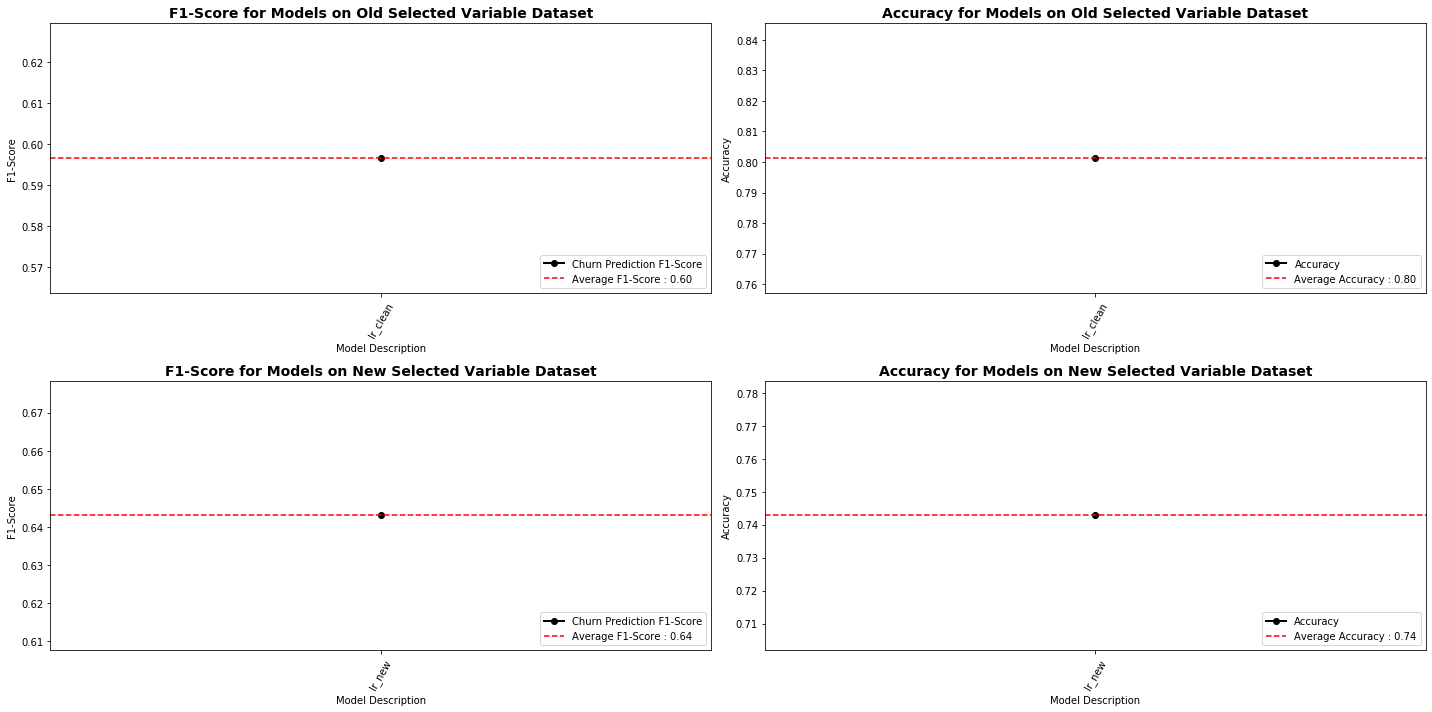

In [12]:
# Plot logistic regression results
f1_dict_clean['lr_clean'] = cr_lr_clean['1']['f1-score']
acc_dict_clean['lr_clean'] = cr_lr_clean['accuracy']
f1_dict_new['lr_new'] = cr_lr_new['1']['f1-score']
acc_dict_new['lr_new'] = cr_lr_new['accuracy']
_ = plot_f1_acc(f1_dict_clean, acc_dict_clean, f1_dict_new, acc_dict_new)

The F1-score for the revised selected feature dataset outperformed the old selected feature dataset by around 5%. Diving deeper into the F1-score, we can see that the revised feature dataset was able to recall users that churned at 67% compared to 55% for the old selected feature dataset. An improved recall score means that the predictive model was able to correctly flag 67% of users that churned as at risk of churning using the 10 chi^2 selected features. This model improvement shows that the model was better able to predict a user would churn if they were paying $75 per month or more on their Telco services.

---

## Decision Tree Classifier

Another predictive model that we used to determine Telco customer churn was the decision tree classifier. The decision tree classifier stands as the baseline model for random forest classification. Now that we have a revised selected feature dataset, let's see how it performs against our previous selected feature dataset.

In [13]:
# Create best-fit decision tree tree model for old and revised selected feature datasets
from sklearn.tree import DecisionTreeClassifier

# Parameters for GridSearchCV
tree_params = { 'criterion' : ['gini', 'entropy'],
                  'max_features' : ['sqrt'],
                  'min_samples_leaf' : [1, 3, 5],
                  'random_state' : [42]}
tree = DecisionTreeClassifier()

# Find best random tree classifier for revised selected feature dataset
best_tree_new = best_clf(tree, tree_params, X_train_new, y_train_new)

# Find best random tree classifier for old selected feature dataset
best_tree_clean = best_clf(tree, tree_params, X_train_clean, y_train_clean)

# Print list of best parameters from GridSearchCV
print(f'Best Parameters for Decision Tree on Old Selected Features: {best_tree_clean.best_params_}')
print(f'Best Parameters for Decision Tree on Revised Selected Features: {best_tree_new.best_params_}')

Best Parameters for Decision Tree on Old Selected Features: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'random_state': 42}
Best Parameters for Decision Tree on Revised Selected Features: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'random_state': 42}


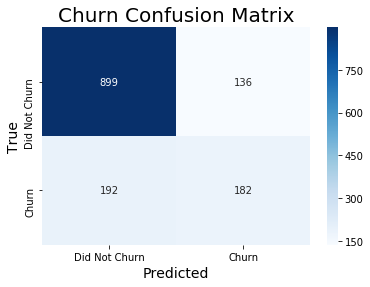

              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1035
           1       0.57      0.49      0.53       374

    accuracy                           0.77      1409
   macro avg       0.70      0.68      0.69      1409
weighted avg       0.76      0.77      0.76      1409



In [14]:
# Generate results from decision tree classification on old selected feature dataset
y_pred_clean_tree = best_tree_clean.predict(X_test_clean)
_ = plot_results(y_test_clean, y_pred_clean_tree)
cr_tree_clean = plot_results(y_test_clean, y_pred_clean_tree, output_dict=True)

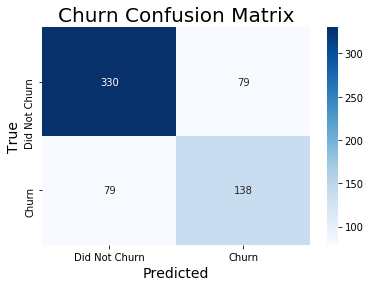

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       409
           1       0.64      0.64      0.64       217

    accuracy                           0.75       626
   macro avg       0.72      0.72      0.72       626
weighted avg       0.75      0.75      0.75       626



In [15]:
# Generate results from decision tree classification on revised selected feature dataset
y_pred_new_tree = best_tree_new.predict(X_test_new)
_ = plot_results(y_test_new, y_pred_new_tree)
cr_tree_new = plot_results(y_test_new, y_pred_new_tree, output_dict=True)

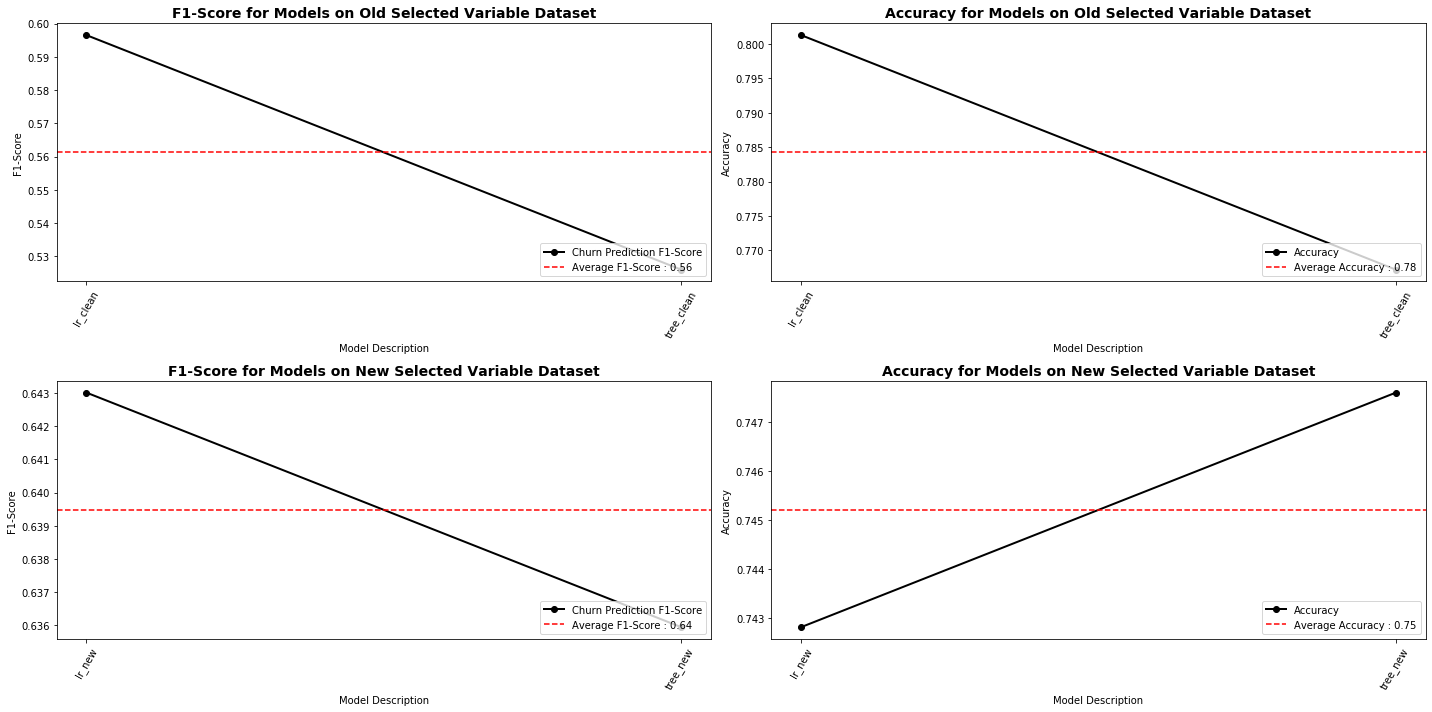

In [16]:
# Plot random tree results
f1_dict_clean['tree_clean'] = cr_tree_clean['1']['f1-score']
acc_dict_clean['tree_clean'] = cr_tree_clean['accuracy']
f1_dict_new['tree_new'] = cr_tree_new['1']['f1-score']
acc_dict_new['tree_new'] = cr_tree_new['accuracy']
_ = plot_f1_acc(f1_dict_clean, acc_dict_clean, f1_dict_new, acc_dict_new)

The decision tree classifier's F1 score dipped by 0.07% with the revised selected feature dataset vs. the nearly 7% dip on the old selected feature dataset. The minimal difference in model performance variance between logistic regression and decision tree classification for the revised dataset suggests that increasing model complexity didn't necessarily improve model performance. This behavior is important to note moving into random forest classification.

---

## Random Forest Classifier

Random forest classification is an ensemble learning method that uses hundreds or thousands of decision trees to cast a majority vote for a predicted label on each given observation. Random forest classification is known for decreasing the variance of decision tree classification while maintaining the low bias for a single decision tree. Normally, we should expect the random forest classifier to outperform decision tree classification in predictive modeling performance.

In [17]:
# Create best-fit random forest models for old and revised selected feature datasets
from sklearn.ensemble import RandomForestClassifier

# Parameters for GridSearchCV
rf_params = {'n_estimators' : [500, 1000, 5000],
          'criterion' : ['gini', 'entropy'],
          'max_features' : ['sqrt'],
          'min_samples_leaf' : [1, 3],
          'random_state' : [42]}
rf = RandomForestClassifier()


# Find best random forest classifier for old selected feature dataset
best_rf_clean = best_clf(rf, rf_params, X_train_clean, y_train_clean)

# Find best random forest classifier for revised selected feature dataset
best_rf_new = best_clf(rf, rf_params, X_train_new, y_train_new)

# Print list of best parameters from GridSearchCV
print(f'Best Parameters for Random Forest on Old Selected Features: {best_rf_clean.best_params_}')
print(f'Best Parameters for Random Forest on Revised Selected Features: {best_rf_new.best_params_}')

Best Parameters for Random Forest on Old Selected Features: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 5000, 'random_state': 42}
Best Parameters for Random Forest on Revised Selected Features: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 1000, 'random_state': 42}


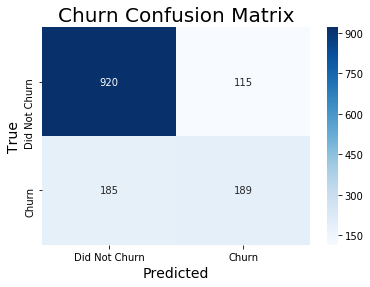

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [18]:
# Generate results from random forest on old selected feature dataset
y_pred_clean_rf = best_rf_clean.predict(X_test_clean)
_ = plot_results(y_test_clean, y_pred_clean_rf)
cr_rf_clean = plot_results(y_test_clean, y_pred_clean_rf, output_dict=True)

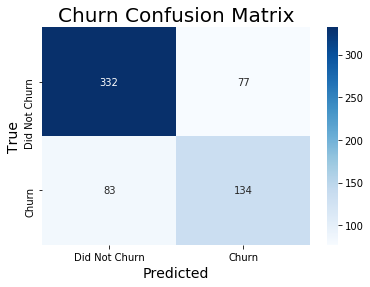

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       409
           1       0.64      0.62      0.63       217

    accuracy                           0.74       626
   macro avg       0.72      0.71      0.72       626
weighted avg       0.74      0.74      0.74       626



In [20]:
# Generate results from random forest on revised selected feature dataset
y_pred_new_rf = best_rf_new.predict(X_test_new)
_ = plot_results(y_test_new, y_pred_new_rf)
cr_rf_new = plot_results(y_test_new, y_pred_new_rf, output_dict=True)

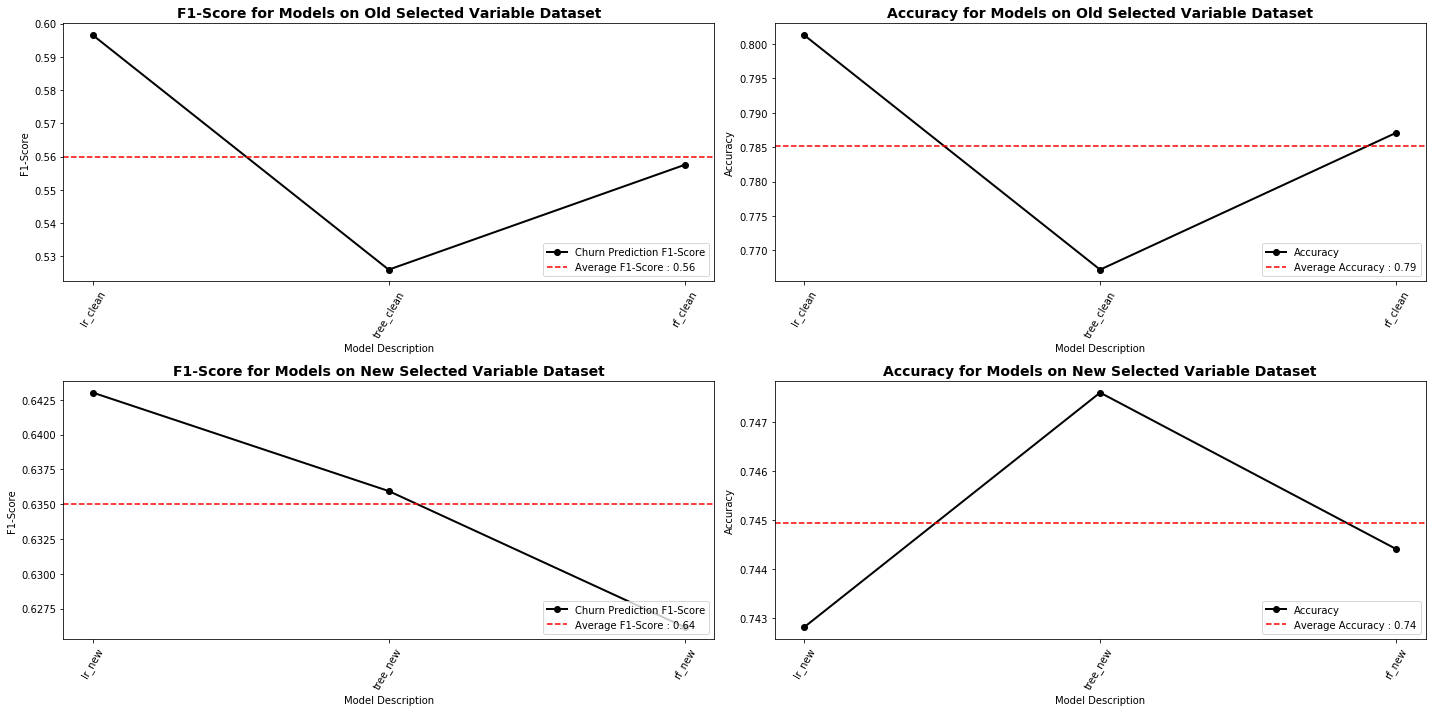

In [21]:
# Plot random forest results
f1_dict_clean['rf_clean'] = cr_rf_clean['1']['f1-score']
acc_dict_clean['rf_clean'] = cr_rf_clean['accuracy']
f1_dict_new['rf_new'] = cr_rf_new['1']['f1-score']
acc_dict_new['rf_new'] = cr_rf_new['accuracy']
_ = plot_f1_acc(f1_dict_clean, acc_dict_clean, f1_dict_new, acc_dict_new)

The random forest classifier on our revised dataset only dropped 0.07% in model performance compared to the decision tree classifier. Again, the similarity in model performance between all three predictive models is curious since each predictive model exhibits varying model complexity which should vary model performance. The similarity in model performance suggests that the churn rate for users that are paying more than $75.00 per month is consistent, regardless of their subscription services. This is incredibly valuable information for Telco. This means that to reduce customer churn, Telco just needs to reduce the total per month cost for users that are paying more than $75.00 per month without focusing on any single subscription service. 

My ultimate suggestion for Telco to improve customer retention is to conduct a 1 year AB Test on customers that are paying $75 per month or more on their Telco services. For the first 3 months of the year, Telco should offer group A with a $15 per month discount and Group B would not receive this discount. Telco should measure customer churn after the 1 year period between groups A and B and determine if the discount incentive program worked. If there's a measurable proportional difference between groups A and B for customer churn rate, Telco can determine the success of this program and deploy annual 3 month discount incentives for all users paying $75 per month or more on Telco services.

Thanks for following this project about customer churn classification. If you enjoyed this content, please follow me on <a href="https://github.com/aldenmchico">GitHub</a> or <a href="https://www.linkedin.com/in/alden-chico/">LinkedIn</a>. It's always fun exploring these data science projects and publishing them out to the world. Thanks for reading through and I'll see you all for the next project.